# Table of Contents
1. [Step 1: Gather the Data](#step1)
1. [Step 2: Prepare Data for Consumption](#step2)
   - [2.1 Import Libraries](#step2.1)
   - [2.1 Meet The Data](#step2.2)
   - [2.3 Clean Data](#step2.3)
   - [2.4 Convert Formats](#step2.4)
1. [Step 3: Visualization](#step3)

<a id="step1"></a>
# Step 1: Gather the Data
The data collected and created at create_ds.ipynb script

<a id="step2"></a>
# Step 2: Prepare Data for Consumption

<a id="step2.1"></a>
## 2.1 Import Libraries

In [1]:
import sys
print("Python version: {}". format(sys.version))

import pandas as pd
print("pandas version: {}". format(pd.__version__))

import numpy as np
print("NumPy version: {}". format(np.__version__))

import scipy as sp
print("SciPy version: {}". format(sp.__version__)) 

import matplotlib
import matplotlib.pyplot as plt
print("matplotlib version: {}". format(matplotlib.__version__))

import seaborn as sns
print("seaborn version: {}". format(sns.__version__))
%matplotlib inline

pd.set_option('display.max_columns', None)
sns.set(style='white', context='notebook', palette='deep')

Python version: 3.7.4 (tags/v3.7.4:e09359112e, Jul  8 2019, 19:29:22) [MSC v.1916 32 bit (Intel)]
pandas version: 1.0.3
NumPy version: 1.18.2
SciPy version: 1.4.1
matplotlib version: 3.2.1
seaborn version: 0.10.0


<a id="step2.2"></a>
## 2.2 Meet The Data

Data explanation should be here

In [2]:
df = pd.read_csv("./input/autotel_with_target.csv",dtype={
    "Order number": "str",
    "Year": "str",
    "Month": "str",
    "Day": "str",
    "Hour": "str",
    "Minute": "str",
} ,index_col=0)

c:\projects\python\ssd\venv\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# print(df.isnull().sum())
# df.describe(include='all')

<a id="step2.3"><a/>
## 2.3 Clean Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136155 entries, 0 to 136154
Data columns (total 36 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Car id                    136155 non-null  object 
 1   Order number              136155 non-null  object 
 2   Category                  136155 non-null  object 
 3   Avg distance              136155 non-null  int64  
 4   Billing minutes           132902 non-null  object 
 5   Address                   136155 non-null  object 
 6   Time                      134980 non-null  object 
 7   kmh                       132860 non-null  float64
 8   Coords                    134957 non-null  object 
 9   Lat                       134957 non-null  float64
 10  Lon                       134957 non-null  float64
 11  neighborhood              134957 non-null  object 
 12  Area                      134957 non-null  float64
 13  Population                134957 non-null  f

### 2.3. Filling empy billing minutes with 0, most of the time its canceled drive

In [5]:
df['Billing minutes'] = pd.to_numeric(df['Billing minutes'],errors='coerce')
df['Billing minutes'] = df['Billing minutes'].fillna(0)

### 2.3. Delete empty adresses

In [6]:
delete_empty_addresses = df["Address"].isnull()

In [7]:
df = df[~delete_empty_addresses]
# This is works too
# df.drop(delete_empty_addresses.index,inplace=True)
# df = df[pd.notnull(df['Address'])]

In [8]:
df["Address"].isnull().sum()

0

### 2.3. Fill na Street_c by Street
the na is only from streets consists only from numbers

In [9]:
df['Street_c'].fillna(df['Street'], inplace = True)

### 2.3. Delete canceled and NO SHOW category rows

In [10]:
df = df[(df['Category'] != 'Canceled') & (df['Category'] != 'NO SHOW')]

### 2.3. Delete empty kmh drives
Those rows with same start and destination addresses and the drive did not happen

In [11]:
df = df[(df['Avg distance'] != 0) & (df['Billing minutes'] != 0)]

### 2.3. Filling na kmh
formula = Avg distance/(Billing minutes/60)

In [12]:
# df['kmh'] = df.apply(lambda row : row['Avg distance']*(row['Billing minutes']/60) if np.isnan(row['kmh']) else row['kmh'],axis=1)

In [13]:
df['kmh'].fillna(df['Avg distance']*(df['Billing minutes']/60),inplace=True)

### 2.3. Filling empty Lat Lon Coords by similar Address rows

In [14]:
AddressCols = ['Address','Lat','Lon','neighborhood','Coords']
df[AddressCols] = df[AddressCols].sort_values(['Address']).ffill()

### 2.3. Filling na weather data with previous data

In [15]:
weatherCols = ['Time','Temprature','Max Temprature','Min Temprature','Relative Humidity','Amount of Rain','Wind Speed','Wind Direction','Max Wind Speed per Min','Max Win Speed per 10 Min']
df[weatherCols] = df[weatherCols].sort_values(['Time']).ffill()

### 2.3. Filling na Area and Population
Filling by same neighborhoods

In [16]:
neighborhoodMetaCols = ["neighborhood","Area","Population"]
df[neighborhoodMetaCols] = df[neighborhoodMetaCols].sort_values(['neighborhood']).ffill()

### 2.3. Delete empty target rows

In [17]:
df.dropna(subset=['count'],inplace=True)

### 2.3. Delete unneeded columns

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91370 entries, 0 to 136152
Data columns (total 36 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Car id                    91370 non-null  object 
 1   Order number              91370 non-null  object 
 2   Category                  91370 non-null  object 
 3   Avg distance              91370 non-null  int64  
 4   Billing minutes           91370 non-null  float64
 5   Address                   91370 non-null  object 
 6   Time                      91370 non-null  object 
 7   kmh                       91370 non-null  float64
 8   Coords                    91370 non-null  object 
 9   Lat                       91370 non-null  float64
 10  Lon                       91370 non-null  float64
 11  neighborhood              91370 non-null  object 
 12  Area                      91370 non-null  float64
 13  Population                91370 non-null  float64
 14  Stree

In [19]:
df.drop(["Car id","Order number","Address","Time","Street","City","Country","Address_c"],axis=1,inplace=True)
# After visualization delete Coords, Date

In [20]:
df.info()
print("\nshape: " + str(df.shape))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91370 entries, 0 to 136152
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Category                  91370 non-null  object 
 1   Avg distance              91370 non-null  int64  
 2   Billing minutes           91370 non-null  float64
 3   kmh                       91370 non-null  float64
 4   Coords                    91370 non-null  object 
 5   Lat                       91370 non-null  float64
 6   Lon                       91370 non-null  float64
 7   neighborhood              91370 non-null  object 
 8   Area                      91370 non-null  float64
 9   Population                91370 non-null  float64
 10  Street_c                  91370 non-null  object 
 11  Address_c2                91370 non-null  object 
 12  Date                      91370 non-null  object 
 13  Year                      91370 non-null  object 
 14  Month

<a id="step3"></a>
# Step 3: Visualization

In [21]:
df.head()

,Category,Avg distance,Billing minutes,kmh,Coords,Lat,Lon,neighborhood,Area,Population,Street_c,Address_c2,Date,Year,Month,Day,Hour,Minute,Temprature,Max Temprature,Min Temprature,Relative Humidity,Amount of Rain,Wind Speed,Wind Direction,Max Wind Speed per Min,Max Win Speed per 10 Min,count
0,שריון חינמי,8,13.0,37.15,"(32.0357011, 34.7581719)",32.04,34.76,(יפו ד' (גבעת התמרים,389591.69,6631.0,הרב רובינשטיין,"הרב רובינשטיין , תל אביב יפו, ישראל",2017-10-23 00:00:00,2017.0,10.0,23.0,0.0,31.0,20.53,20.8,20.1,66.67,0.0,2.53,117.0,3.2,2.7,1.0
1,שריון חינמי,3,8.0,21.56,"(32.0895831, 34.7734306)",32.09,34.77,הצפון הישן - החלק הצפוני,1819996.41,32080.0,ז'בוטינסקי,"ז'בוטינסקי , תל אביב יפו, ישראל",2017-10-23 00:00:00,2017.0,10.0,23.0,0.0,21.0,20.53,20.8,20.1,66.67,0.0,2.53,117.0,3.2,2.7,1.0
3,שריון חינמי,4,9.0,26.23,"(32.0957684, 34.7956908)",32.10,34.80,בבלי,789096.26,9403.0,אונקלוס,"אונקלוס , תל אביב יפו, ישראל",2017-10-23 00:00:00,2017.0,10.0,23.0,0.0,23.0,20.53,20.8,20.1,66.67,0.0,2.53,117.0,3.2,2.7,9.0
4,שריון חינמי,2,6.0,18.66,"(32.0807886, 34.7793035)",32.08,34.78,הצפון הישן-החלק הדרומי,1348333.36,29394.0,גורדון,"גורדון , תל אביב יפו, ישראל",2017-10-23 00:00:00,2017.0,10.0,23.0,0.0,21.0,20.53,20.8,20.1,66.67,0.0,2.53,117.0,3.2,2.7,9.0
5,שריון חינמי,4,12.0,19.43,"(32.05569380000001, 34.7560594)",32.06,34.76,צפון יפו,838596.18,8037.0,רציף העלייה השניה,"רציף העלייה השניה , תל אביב יפו, ישראל",2017-10-23 00:00:00,2017.0,10.0,23.0,0.0,28.0,20.53,20.8,20.1,66.67,0.0,2.53,117.0,3.2,2.7,21.0


### Plot drives by neighborhoods

In [193]:
nei = df['neighborhood'].value_counts().reset_index(level=0)
nei_more_then = nei[nei.neighborhood > 2000]
nei_more_then['index'] = nei_more_then.loc[:,'index'].apply(lambda x: x[::-1])
nei_more_then

c:\projects\python\ssd\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,neighborhood
0,ביבא-לת בל,11406
1,ינופצה קלחה - ןשיה ןופצה,9991
2,ימורדה קלחה-ןשיה ןופצה,7506
3,הנידמה רככ תביבס-שדחה ןופצה,4295
4,ימורדה קלחה-שדחה ןופצה,3508
5,ןיטנרולפ,3179
6,התביבסו םיביבא הונ,2971
7,ופי ןופצ,2726
8,ינופצה קלחה - שדחה ןופצה,2581
9,"א""ת תטיסרבינוא",2334


([<matplotlib.axis.YTick at 0x1ea850d0>,
 <a list of 10 Text major ticklabel objects>)

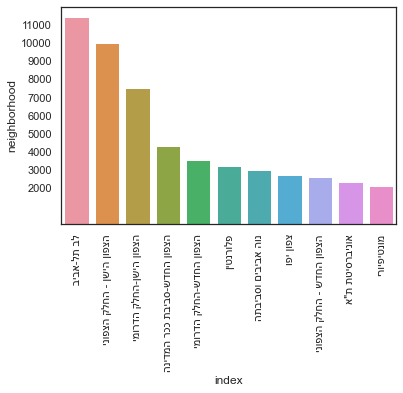

In [217]:
g = sns.barplot(x=nei_more_then['index'],y=nei_more_then['neighborhood'])
plt.xticks(rotation=90)
plt.yticks(np.arange(int(nei_more_then['neighborhood'].min()/1000)*1000, nei_more_then['neighborhood'].max(), 1000)) 
# sns.barplot(x=df.neighborhood.value_counts().index, y=df.neighborhood.value_counts())